# 🤖 Use RNN Models to Identify MPox

## 🗂️ Import Libraries

The following code block imports all the libraries that are necessary for our development purposes.

#### 🔢 `numpy`
- NumPy is a powerful Python library used for numerical computing, providing support for large, multi-dimensional arrays, matrices, and high-level mathematical functions to operate on them efficiently.

#### 🐼 `pandas`
- Pandas is a Python library designed for data manipulation and analysis, offering easy-to-use data structures like DataFrames and Series for handling structured data efficiently.

#### 👣 `pathlib`
- Pathlib is a Python library that provides an object-oriented interface for working with filesystem paths, making path manipulation and file operations more intuitive and cross-platform.

#### 📈 `matplotlib`
- Matplotlib is a Python library for creating static, interactive, and animated visualizations in a variety of formats, including plots, graphs, and charts.

#### ⚡ `tensorflow`
- TensorFlow is an open-source library designed for building and deploying machine learning and deep learning models, offering a flexible ecosystem for numerical computation and AI development.

#### 🧠 `keras`
- Keras is a high-level deep learning library in Python that simplifies the creation and training of neural networks by providing an intuitive interface to underlying frameworks like TensorFlow.

#### 🌊 `seaborn`
- Seaborn is a Python library built on Matplotlib that simplifies creating aesthetically pleasing and informative statistical graphics for data visualization.

#### 💻 `os`
- The os library in Python provides a way to interact with the operating system, enabling tasks such as file and directory manipulation, environment variable access, and process management.

#### 🔬 `scikit-learn`
- Scikit-learn is a Python library that provides simple and efficient tools for data mining, data analysis, and machine learning, including classification, regression, and clustering algorithms.

#### 📄 `shutil`
- The shutil library in Python provides a suite of functions for high-level file operations, including copying, moving, renaming, and deleting files and directories.

### 🎲 `random`
- The random library in Python provides functions to generate random numbers, select random elements, and perform random operations like shuffling and sampling, useful for simulations, games, and probabilistic programming.

### ⚠️ `warnings`
- The warnings library in Python is used to issue, control, and filter warning messages during runtime, helping developers identify and address potential issues in their code without interrupting program execution.

In [1]:
# 🗂️ Import Libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, img_to_array, load_img
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import random
import os
import shutil

# Supress warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## ♾️ Constants

While proceeding with the process, we need some constants that may refer to the directory paths, image category names, data generation properties, etc.

In [2]:
# ♾️ Constants

# Directory paths
DATA_PATH = './data/original'
AUGMENTED_PATH = './data/rnn_augmented'
RNN_BALANCED_PATH = './data/rnn_balanced'
MODELS_PATH = './models/rnn'

TRAIN_DIRECTORY='train'
TEST_DIRECTORY='test'
VALIDATION_DIRECTORY ='val'

# Sample Values
TRAIN_DATASET_SAMPLE_COUNT=1000
TEST_DATASET_SAMPLE_COUNT=200
VALIDATION_DATASET_SAMPLE_COUNT=200

# Directories containing the images
SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
DATA_DIRECTORIES = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'Healthy', 'HFMD', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']

# Data generation properties
ROTATION_RANGE = 40
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
HORIZONTAL_FLIP = True
FILL_MODE = 'nearest'

# Model-related constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = len(DATA_DIRECTORIES)
BATCH_SIZE = 32
EPOCHS = 20

## 🧮 Get Number of Images

Get the number of images in each directory and sub-directory to get an understanding of the dataset.

In [3]:
# 🧮 Get Number of Images

# This method is used to get the number of images in each of the directories in our dataset
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"{dataset_type}")
        print("----------------------------")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg', 'jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
        print("")

In [4]:
# Execute the method
count_images(DATA_PATH)

train
----------------------------
Number of images in Benign keratosis-like lesions: 2099
Number of images in Cowpox: 792
Number of images in Healthy: 1368
Number of images in Actinic keratoses: 693
Number of images in Melanoma: 3617
Number of images in HFMD: 1932
Number of images in Melanocytic nevi: 10300
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Basal cell carcinoma: 2658
Number of images in Squamous cell carcinoma: 502
Number of images in Monkeypox: 3408
Number of images in Dermatofibroma: 191
Number of images in Vascular lesions: 202

test
----------------------------
Number of images in Benign keratosis-like lesions: 263
Number of images in Cowpox: 99
Number of images in Healthy: 171
Number of images in Actinic keratoses: 88
Number of images in Melanoma: 453
Number of images in HFMD: 242
Number of images in Melanocytic nevi: 1288
Number of images in Measles: 83
Number of images in Chickenpox: 113
Number of images in Basal cell carci

## 🗜️ Image Augmentation for Categories with Low Image Count

Since the image count is low on the following we need to augment those images. Then, we can add the original images and a set of augmented images for our model creation.

***train*** Dataset (<1000)
- *Cowpox*
- *Actinic keratoses*
- *Measels*
- *Chickenpox*
- *Squamous cell carcinoma*
- *Dermatofibroma*
- *Vascular lesions*

***test*** Dataset (<200)
- *Cowpox*
- *Healthy*
- *Actinic keratoses*
- *Measels*
- *Chickenpox*
- *Squamous cell carcinoma*
- *Dermatofibroma*
- *Vascular lesions*

***val*** Dataset (<200)
- *Cowpox*
- *Healthy*
- *Actinic keratoses*
- *Measels*
- *Chickenpox*
- *Squamous cell carcinoma*
- *Dermatofibroma*
- *Vascular lesions*

### 💾 Define Data Generation Properties
To augment images we need to use something called `ImageDataGenerator`. To use that we need to define data-gen properties. This way more data is generated according to the parameters we define. The parameters we will be using for this are as follows.

- ↻ `rotation_range`
    - Specifies the range(in degrees) within which the image is randomly rotated.
    - For example, a value of `40` means the image can be rotated randomly by up to `40` degrees in either direction(clockwise or counterclockwise).<br><br>
    
- ↔ `width_shift_range`
    - Specifies the fraction of the total width of the image by which it can be randomly shifted horizontally.
    - For example, a value of `0.2` allows a horizontal shift of up to `20%` of the image's width.<br><br>
    
- ↕ `height_shift_range`
    - Specifies the fraction of the total height of the image by which it can be randomly shifted vertically.
    - For example, a value of `0.2` allows a vertical shift of up to `20%` of the image's height.<br><br>
  
- ➤ `shear_range`
    - Specifies the intensity of shear transformation as a shear angle in a counterclockwise direction in degrees.
    - A shear transformation distorts the image along an axis creating a parallelogram effect.<br><br>

- 🔎 `zoom_range`
   - Specifies the range for random zoom. It can zoom in or out within this range.
   - For example, a value of `0.2` means the image size can be varied randomly by up to `±20%`.<br><br>

- ― `horizontal_flip`
   - Specifies whether the image should be flipped horizontally.
   - If `True`, the image is randomly flipped along the horizontal axis, mirroring it.<br><br>

- 🚰 `fill_mode`
   - Specifies the strategy for filling in pixels that are introduced during transformations.
   - The value `nearest` means the nearest pixel values are used to fill these gaps.

In [5]:
# 🗜️ Image Augmentation for Categories with Low Image Count

# Define directories that lack the images count
TRAIN_IMAGE_AUGEMENTATION_DIRS = ['Cowpox', 'Actinic keratoses', 'Measles', 'Chickenpox', 'Squamous cell carcinoma', 'Dermatofibroma', 'Vascular lesions']
TEST_IMAGE_AUGEMENTATION_DIRS = ['Cowpox', 'Healthy', 'Actinic keratoses', 'Measles', 'Chickenpox', 'Squamous cell carcinoma', 'Dermatofibroma', 'Vascular lesions']
VAL_IMAGE_AUGEMENTATION_DIRS = ['Cowpox', 'Healthy', 'Actinic keratoses', 'Measles', 'Chickenpox', 'Squamous cell carcinoma', 'Dermatofibroma', 'Vascular lesions']

# Create Image Generator
datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    fill_mode=FILL_MODE)

# Function to process and augment data
def augment_and_copy_data(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        dir_type = os.path.join(dir_name, dataset_type)
        # Dependeing on the dataset_type pick the categories with less number of images
        categories = []
        if dataset_type == TRAIN_DIRECTORY:
            categories = TRAIN_IMAGE_AUGEMENTATION_DIRS
        elif dataset_type == TEST_DIRECTORY:
            categories = TEST_IMAGE_AUGEMENTATION_DIRS
        else:
            categories = VAL_IMAGE_AUGEMENTATION_DIRS
        for category in categories:
            category_path = os.path.join(dir_type, category)
            # Get augmented dataset path (e.g. ./data/augmented/train)
            augmented_path = os.path.join(AUGMENTED_PATH, dataset_type)
            # Create the dataset type directory if it does not exist
            os.makedirs(augmented_path, exist_ok=True)
            # Get augmented category path (e.g. ./data/augmented/train/Cowpox)
            augmented_category_path = os.path.join(augmented_path, category)
            # Create a directory if it does not exist
            os.makedirs(augmented_category_path, exist_ok=True)

            # Get all the files inside a category directory
            files = os.listdir(category_path)

            print(f'Started augmenting images in: {category_path}')

            # Iterate files
            for file in files:
                if file.startswith('.'): ### Skip hidden files
                    continue
                # Load images
                img_path = os.path.join(category_path, file)
                img = load_img(str(img_path))
                x = img_to_array(img) #### This is a NumPy array with shape (3, 150, 150)
                x = x.reshape((1,) + x.shape) #### This is a NumPy array with shape (1, 3, 150, 150)
                # The .flow() command generates batches of randomly transformed images and saves the results in the ./data/augmented/<sub_directory>/<data_directory> along with the original image
                # print(f'Started augmenting image: {img_path}')
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_category_path, save_prefix=file.split(".")[0], save_format='jpg'):
                    i += 1
                    if i > 10:
                        break # Stop looping the generator infinitely

In [6]:
# Execute the method
augment_and_copy_data(DATA_PATH)

Started augmenting images in: ./data/original/train/Cowpox
Started augmenting images in: ./data/original/train/Actinic keratoses
Started augmenting images in: ./data/original/train/Measles
Started augmenting images in: ./data/original/train/Chickenpox
Started augmenting images in: ./data/original/train/Squamous cell carcinoma
Started augmenting images in: ./data/original/train/Dermatofibroma
Started augmenting images in: ./data/original/train/Vascular lesions
Started augmenting images in: ./data/original/test/Cowpox
Started augmenting images in: ./data/original/test/Healthy
Started augmenting images in: ./data/original/test/Actinic keratoses
Started augmenting images in: ./data/original/test/Measles
Started augmenting images in: ./data/original/test/Chickenpox
Started augmenting images in: ./data/original/test/Squamous cell carcinoma
Started augmenting images in: ./data/original/test/Dermatofibroma
Started augmenting images in: ./data/original/test/Vascular lesions
Started augmenting i

## ⚖️ Create a Balanced Dataset

We need to create a balanced dataset to use the RNN models more effectively. The lowest number of images in category directories of the `train` dataset is 191. Therefore, we can create a balanced dataset containing 191 images from each category directory.

To do that we can create a method named `create_balanced_dataset` with three inputs, `source_dir`, `dest_dir`, and `num_images`. 

In [7]:
# ⚖️ Create a Balanced Dataset

# This method is used to copy a certain number of images from every, train, test, and validation set.
def limit_data_from_source(source_dir, dest_dir, num_images=TRAIN_DATASET_SAMPLE_COUNT):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for dataset_type in SUB_DIRECTORIES:
        source_type_dir = os.path.join(source_dir, dataset_type)
        dest_type_dir = os.path.join(dest_dir, dataset_type)
        os.makedirs(dest_type_dir, exist_ok=True)
        for category in os.listdir(source_type_dir):
            category_path = os.path.join(source_type_dir, category)
            if not os.path.isdir(category_path):
                continue
            dest_category_path = os.path.join(dest_type_dir, category)
            os.makedirs(dest_category_path, exist_ok=True)

            images = [img for img in os.listdir(category_path) if img.endswith(('jpg', 'jpeg'))]
            print(f"Number of images in {dataset_type}/{category_path.split('/')[-1]}: {len(images)}")
            # Select the number of images provided in num_images param or the minimum number of images
            if dataset_type == TRAIN_DIRECTORY:
                num_images = TRAIN_DATASET_SAMPLE_COUNT
            elif dataset_type == TEST_DIRECTORY:
                num_images = TEST_DATASET_SAMPLE_COUNT
            else:
                num_images = VALIDATION_DATASET_SAMPLE_COUNT
            selected_images = random.sample(images, min(num_images, len(images)))

            for image in selected_images:
                source_image_path = os.path.join(category_path, image)
                dest_image_path = os.path.join(dest_category_path, image)
                # print(f'Copying {source_image_path} to {dest_image_path}')
                shutil.copy(source_image_path, dest_image_path)          

In [8]:
limit_data_from_source(DATA_PATH, RNN_BALANCED_PATH)

Number of images in train/Benign keratosis-like lesions: 2099
Number of images in train/Cowpox: 792
Number of images in train/Healthy: 1368
Number of images in train/Actinic keratoses: 693
Number of images in train/Melanoma: 3617
Number of images in train/HFMD: 1932
Number of images in train/Melanocytic nevi: 10300
Number of images in train/Measles: 660
Number of images in train/Chickenpox: 900
Number of images in train/Basal cell carcinoma: 2658
Number of images in train/Squamous cell carcinoma: 502
Number of images in train/Monkeypox: 3408
Number of images in train/Dermatofibroma: 191
Number of images in train/Vascular lesions: 202
Number of images in test/Benign keratosis-like lesions: 263
Number of images in test/Cowpox: 99
Number of images in test/Healthy: 171
Number of images in test/Actinic keratoses: 88
Number of images in test/Melanoma: 453
Number of images in test/HFMD: 242
Number of images in test/Melanocytic nevi: 1288
Number of images in test/Measles: 83
Number of images i

## ➕ Add the Augmented Images to the Balanced Dataset to Balance the Number of Images

The next step is to identify the number of missing images from the balanced dataset and add the missing images from the augmented images.

In [9]:
count_images(RNN_BALANCED_PATH)

train
----------------------------
Number of images in Benign keratosis-like lesions: 1000
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in Actinic keratoses: 693
Number of images in Melanoma: 1000
Number of images in HFMD: 1000
Number of images in Melanocytic nevi: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Basal cell carcinoma: 1000
Number of images in Squamous cell carcinoma: 502
Number of images in Monkeypox: 1000
Number of images in Dermatofibroma: 191
Number of images in Vascular lesions: 202

test
----------------------------
Number of images in Benign keratosis-like lesions: 200
Number of images in Cowpox: 99
Number of images in Healthy: 171
Number of images in Actinic keratoses: 88
Number of images in Melanoma: 200
Number of images in HFMD: 200
Number of images in Melanocytic nevi: 200
Number of images in Measles: 83
Number of images in Chickenpox: 113
Number of images in Basal cell carcino

In [10]:
# Since there are missing images, we need to find out exactly how many images we are missing by creating dictiionaries for each of the test, train, and val directories.

# Function for getting missing image count for train, test, and val
def get_missing_images_count(dir_name):
    # Create dictionaries for train, test, and validation
    train_dict = dict()
    test_dict = dict()
    val_dict = dict()
    for dataset_type in SUB_DIRECTORIES:
        dir_type = os.path.join(dir_name, dataset_type)
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg', 'jpeg'))]
            required_count = 0
            if dataset_type == TRAIN_DIRECTORY:
                image_count = min(len(images), TRAIN_DATASET_SAMPLE_COUNT)
                required_count = TRAIN_DATASET_SAMPLE_COUNT - image_count
                train_dict[category_path.split("/")[-1]] = required_count
            elif dataset_type == TEST_DIRECTORY:
                image_count = min(len(images), TEST_DATASET_SAMPLE_COUNT)
                required_count = TEST_DATASET_SAMPLE_COUNT - image_count
                test_dict[category_path.split("/")[-1]] = required_count
            else:
                image_count = min(len(images), VALIDATION_DATASET_SAMPLE_COUNT)
                required_count = VALIDATION_DATASET_SAMPLE_COUNT - image_count
                val_dict[category_path.split("/")[-1]] = required_count
    return train_dict, test_dict, val_dict

In [11]:
# ➕ Add the Augmented Images to the Balanced Dataset to Balance the Number of Images

# Get the missing number of images
train_dict, test_dict, val_dict = get_missing_images_count(RNN_BALANCED_PATH)

# Print the missing values
def print_dict(dict_name, dataset_type):
    print(f"Missing values in {dataset_type}")
    print("----------------------------")
    for key, value in train_dict.items():
        print(f"{key} : {value}")

# print train_dict key, value pairs
print_dict(train_dict, TRAIN_DIRECTORY)

# print test_dict key, value pairs
print_dict(test_dict, TEST_DIRECTORY)

# print val_dict key, value pairs
print_dict(val_dict, VALIDATION_DIRECTORY)

Missing values in train
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 208
Healthy : 0
Actinic keratoses : 307
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 340
Chickenpox : 100
Basal cell carcinoma : 0
Squamous cell carcinoma : 498
Monkeypox : 0
Dermatofibroma : 809
Vascular lesions : 798
Missing values in test
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 208
Healthy : 0
Actinic keratoses : 307
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 340
Chickenpox : 100
Basal cell carcinoma : 0
Squamous cell carcinoma : 498
Monkeypox : 0
Dermatofibroma : 809
Vascular lesions : 798
Missing values in val
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 208
Healthy : 0
Actinic keratoses : 307
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 340
Chickenpox : 100
Basal cell carcinoma : 0
Squamous cell carcinoma : 498
Monkeypox : 0
Dermatofibroma : 809
Vascular lesions : 798


In [12]:
# Function to copy the missing number of images randomly from the augmented dataset
def copy_missing_images_from_augmented(src_path, dest_path):
    # Get the missing image count
    train_dict, test_dict, val_dict = get_missing_images_count(RNN_BALANCED_PATH)

    # Dictionary mapping dataset types to their corresponding missing counts
    missing_counts = {
        TRAIN_DIRECTORY: train_dict,
        TEST_DIRECTORY: test_dict,
        VALIDATION_DIRECTORY: val_dict,
    }

    for dataset_type in SUB_DIRECTORIES:
        src_dir_type = os.path.join(src_path, dataset_type)
        dest_dir_type = os.path.join(dest_path, dataset_type)

        # Pass the dictionary for the current dataset type
        copy_images_for_dataset_type(src_dir_type, dest_dir_type, missing_counts[dataset_type])

# Helper function to copy images for a specific dataset type
def copy_images_for_dataset_type(src_dir, dest_dir, missing_dict):
    for key, value in missing_dict.items():
        if value == 0:
            continue
        src_cat_dir = os.path.join(src_dir, key)
        dest_cat_dir = os.path.join(dest_dir, key)

        # Get all available images in the source category directory
        images = [img for img in os.listdir(src_cat_dir) if img.endswith(('jpg', 'jpeg'))]

        # Randomly select the missing number of images
        selected_images = random.sample(images, min(value, len(images)))

        # Copy the selected images to the destination directory
        for img in selected_images:
            shutil.copy(os.path.join(src_cat_dir, img), dest_cat_dir)

In [13]:
# Copy the missing images from augmented images
copy_missing_images_from_augmented(AUGMENTED_PATH, RNN_BALANCED_PATH)

# Count the number of images again
train_dict, test_dict, val_dict = get_missing_images_count(RNN_BALANCED_PATH)

# print train_dict key, value pairs
print_dict(train_dict, TRAIN_DIRECTORY)

# print test_dict key, value pairs
print_dict(test_dict, TEST_DIRECTORY)

# print val_dict key, value pairs
print_dict(val_dict, VALIDATION_DIRECTORY)

Missing values in train
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 0
Healthy : 0
Actinic keratoses : 0
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 0
Chickenpox : 0
Basal cell carcinoma : 0
Squamous cell carcinoma : 0
Monkeypox : 0
Dermatofibroma : 0
Vascular lesions : 0
Missing values in test
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 0
Healthy : 0
Actinic keratoses : 0
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 0
Chickenpox : 0
Basal cell carcinoma : 0
Squamous cell carcinoma : 0
Monkeypox : 0
Dermatofibroma : 0
Vascular lesions : 0
Missing values in val
----------------------------
Benign keratosis-like lesions : 0
Cowpox : 0
Healthy : 0
Actinic keratoses : 0
Melanoma : 0
HFMD : 0
Melanocytic nevi : 0
Measles : 0
Chickenpox : 0
Basal cell carcinoma : 0
Squamous cell carcinoma : 0
Monkeypox : 0
Dermatofibroma : 0
Vascular lesions : 0


## 🗃️ Creating File Data Frame for Train Dataset

Now, we have all the required images to make our RNN model.

Next, to make our RNN model, we need to create a data frame that will contain the paths and the names of the dermatological diseases. 

After creating the data frame, we can check whether there is a data imbalance with a pie chart.

In [14]:
# 🗃️ Creating File Data Frame for Train Dataset
def load_images_to_df(base_path, dataset_type, sample_size):
    # Load the base directory path
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    # Get file paths and assign labels
    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate file paths and labels
    image_df = pd.concat([file_paths, labels], axis=1)

    # Get samples according to the sample size
    samples =[]
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label'] == record].sample(sample_size, random_state=42))
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    # Return the data frame
    return image_df

In [15]:
# Get the images of the train set
image_df_train = load_images_to_df(RNN_BALANCED_PATH, TRAIN_DIRECTORY, TRAIN_DATASET_SAMPLE_COUNT)

# Show output
image_df_train.head(10)

,Path,Label
0,data/rnn_balanced/train/Healthy/HEALTHY_06_01_...,Healthy
1,data/rnn_balanced/train/Actinic keratoses/ISIC...,Actinic keratoses
2,data/rnn_balanced/train/Chickenpox/CHP_30_01_3...,Chickenpox
3,data/rnn_balanced/train/Actinic keratoses/ISIC...,Actinic keratoses
4,data/rnn_balanced/train/Chickenpox/CHP_05_01_9...,Chickenpox
5,data/rnn_balanced/train/Measles/MSL_04_01_6.jpg,Measles
6,data/rnn_balanced/train/Chickenpox/CHP_53_01_7...,Chickenpox
7,data/rnn_balanced/train/Measles/MSL_39_01_12_0...,Measles
8,data/rnn_balanced/train/Squamous cell carcinom...,Squamous cell carcinoma
9,data/rnn_balanced/train/HFMD/HFMD_129_01_ORIGI...,HFMD


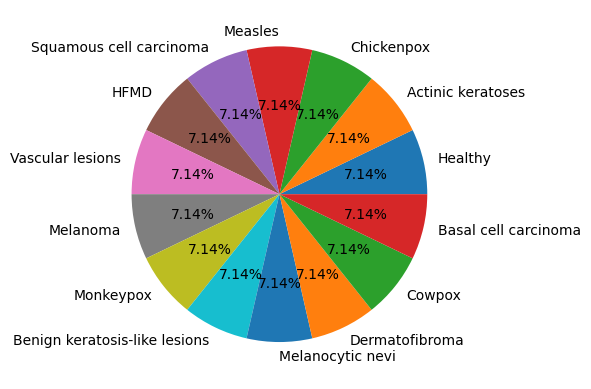

In [16]:
# Show the number of images to show there are no biases in the image set
pie = image_df_train['Label'].value_counts()
pie.plot(kind='pie', autopct='%1.2f%%')
plt.ylabel('')
plt.show()

## 🖥️ Display Images of the Dataset

Since we see that there is no data imbalance, the next step is to see whether our data has been loaded correctly or not in our data frame.

We can check that by plotting a sample of our images. To do that, we can use the `matplotlib` library.

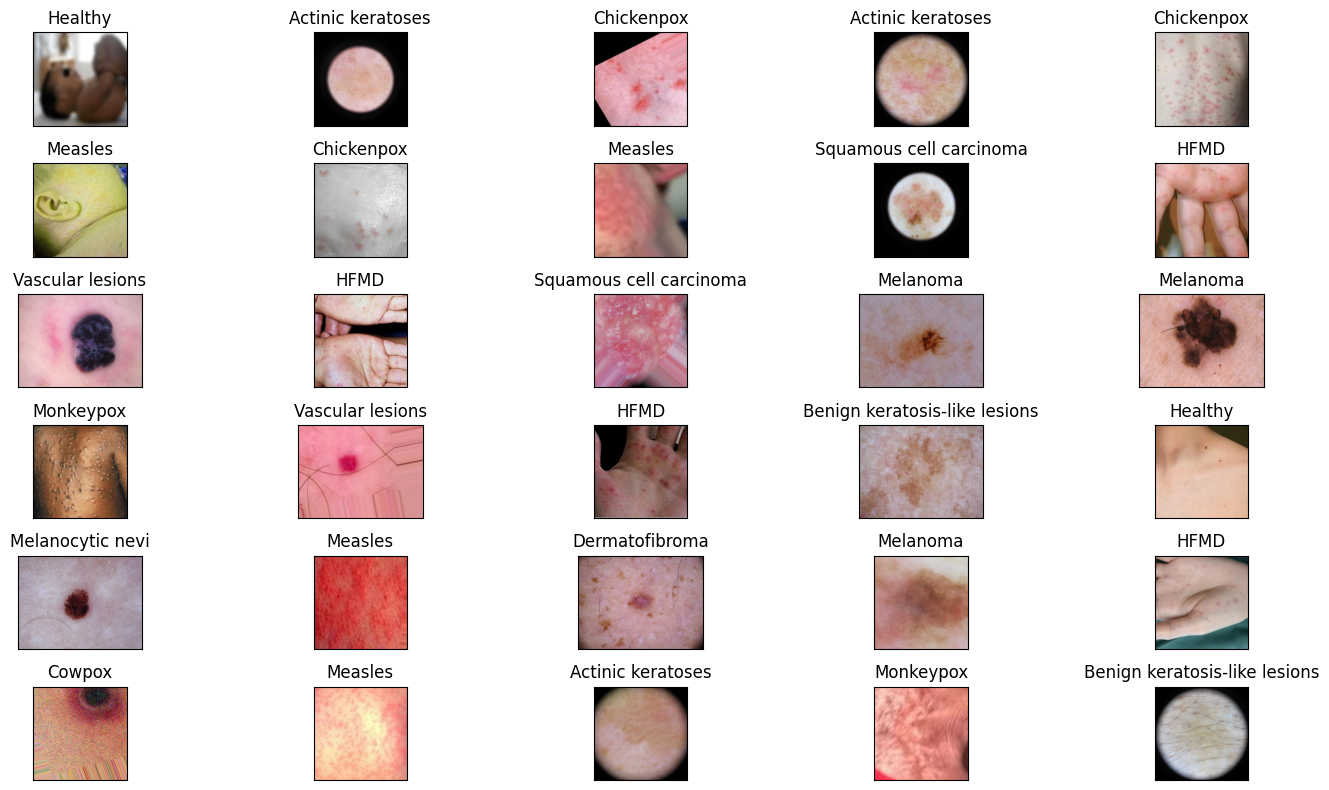

In [17]:
# 🖥️ Display Images of the Dataset

# Define figure and axes
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,8), subplot_kw={'xticks':[], 'yticks':[]})

# Display 30 images of the dataset
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df_train.Path[i], -1))
    ax.set_title(image_df_train.Label[i])
plt.tight_layout()
plt.show()

## 🗃️ Load the Test and Validation Data Frames

Next, load the test and validation data frames so that we can use them to create the models.

In [18]:
# 🗃️ Load the Test and Validation Data Frames
image_df_test = load_images_to_df(RNN_BALANCED_PATH, TEST_DIRECTORY, TEST_DATASET_SAMPLE_COUNT)
image_df_test.head(10)

,Path,Label
0,data/rnn_balanced/test/HFMD/HFMD_16_03_1.jpg,HFMD
1,data/rnn_balanced/test/Actinic keratoses/ISIC_...,Actinic keratoses
2,data/rnn_balanced/test/Squamous cell carcinoma...,Squamous cell carcinoma
3,data/rnn_balanced/test/HFMD/HFMD_78_01.jpg,HFMD
4,data/rnn_balanced/test/Basal cell carcinoma/IS...,Basal cell carcinoma
5,data/rnn_balanced/test/Chickenpox/CHP_14_01_7.jpg,Chickenpox
6,data/rnn_balanced/test/Melanocytic nevi/ISIC_0...,Melanocytic nevi
7,data/rnn_balanced/test/Measles/MSL_22_01_4_0_8...,Measles
8,data/rnn_balanced/test/Monkeypox/MKP_29_02_5.jpg,Monkeypox
9,data/rnn_balanced/test/HFMD/HFMD_21_01_ORIGINA...,HFMD


In [19]:
image_df_val = load_images_to_df(RNN_BALANCED_PATH, VALIDATION_DIRECTORY, VALIDATION_DATASET_SAMPLE_COUNT)
image_df_val.head(10)

,Path,Label
0,data/rnn_balanced/val/HFMD/HFMD_98_01_4.jpg,HFMD
1,data/rnn_balanced/val/Actinic keratoses/ISIC_0...,Actinic keratoses
2,data/rnn_balanced/val/Squamous cell carcinoma/...,Squamous cell carcinoma
3,data/rnn_balanced/val/HFMD/HFMD_49_01_9.jpg,HFMD
4,data/rnn_balanced/val/Basal cell carcinoma/ISI...,Basal cell carcinoma
5,data/rnn_balanced/val/Chickenpox/CHP_15_02_6_0...,Chickenpox
6,data/rnn_balanced/val/Melanocytic nevi/ISIC_00...,Melanocytic nevi
7,data/rnn_balanced/val/Measles/MSL_44_01_3_0_38...,Measles
8,data/rnn_balanced/val/Monkeypox/MKP_83_01_3.jpg,Monkeypox
9,data/rnn_balanced/val/HFMD/HFMD_117_01_12.jpg,HFMD


In [20]:
def preprocess_images(df, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = tf.keras.utils.load_img(row['Path'], target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)/255.0 # Normalize
        img_array = img_array.reshape(img_height, -1) # Flatten into rows(sequential data)
        images.append(img_array)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

In [21]:
# Load training data
train_images, train_labels = preprocess_images(image_df_train)
val_images, val_labels = preprocess_images(image_df_val)
test_images, test_labels = preprocess_images(image_df_test)

In [22]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(test_labels)
test_labels = label_encoder.transform(test_labels)

In [23]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, NUM_CLASSES)
val_labels = to_categorical(val_labels, NUM_CLASSES)
test_labels = to_categorical(test_labels, NUM_CLASSES)

## ✨ Create Model
The following functions are used to create the models and train them.

In [24]:
# Function to build LSTM Model
def build_model_lstm(hp):
    model = Sequential()

    # First LSTM layer with a tunable number of units
    model.add(LSTM(units=hp.Int('units_lstm_1', min_value=64, max_value=256, step=64),
    input_shape=(IMG_HEIGHT, IMG_WIDTH *3),
    return_sequences=True))

    # Second LSTM layer with a tunable number of units
    model.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=128, step=32)))

    # Dropout layer with tunable rate
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense layer witha  tunable number of units
    model.add(Dense(units=hp.Int('units_dense', min_value=16, max_value=64, step=16), activation='relu'))

    # Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model_lstm,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='LSTM'
)

2025-01-20 00:18:51.670495: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-20 00:18:51.670734: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-20 00:18:51.670932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-20 00:18:51.671574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-20 00:18:51.671612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
# Define an early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
# Run the hyperparameter search
tuner.search(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    callbacks=[stop_early],
    batch_size=BATCH_SIZE
)

Trial 30 Complete [00h 03m 19s]
val_accuracy: 0.0625

Best val_accuracy So Far: 0.11178571730852127
Total elapsed time: 01h 26m 36s


In [28]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Units in LSTM Layer 1: {best_hps.get('units_lstm_1')}
- Units in LSTM Layer 2: {best_hps.get('units_lstm_2')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Units in Dense Layer: {best_hps.get('units_dense')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best hyperparameters:
- Units in LSTM Layer 1: 64
- Units in LSTM Layer 2: 32
- Dropout Rate: 0.30000000000000004
- Units in Dense Layer: 16
- Learning Rate: 0.001



In [29]:
# Build the best model and retrain
best_model = tuner.hypermodel.build(best_hps)

In [30]:
# Get history
history = best_model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[stop_early])

Epoch 1/20


2025-01-20 01:46:23.730201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:46:24.005773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:46:24.090283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/438 [..............................] - ETA: 11:57 - loss: 2.6391 - accuracy: 0.1250

2025-01-20 01:46:24.238280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:46:24.344325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 2.6394 - accuracy: 0.0699

2025-01-20 01:46:42.462310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:46:42.540215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:46:42.581765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 21s 45ms/step - loss: 2.6394 - accuracy: 0.0699 - val_loss: 2.7042 - val_accuracy: 0.0714
Epoch 2/20
438/438 [==============================] - 14s 33ms/step - loss: 2.6393 - accuracy: 0.0669 - val_loss: 2.7044 - val_accuracy: 0.0707
Epoch 3/20
438/438 [==============================] - 14s 33ms/step - loss: 2.6393 - accuracy: 0.0676 - val_loss: 2.7041 - val_accuracy: 0.0796
Epoch 4/20
438/438 [==============================] - 14s 33ms/step - loss: 2.6393 - accuracy: 0.0666 - val_loss: 2.7039 - val_accuracy: 0.0793
Epoch 5/20
438/438 [==============================] - 14s 33ms/step - loss: 2.6393 - accuracy: 0.0674 - val_loss: 2.7038 - val_accuracy: 0.0771
Epoch 6/20
438/438 [==============================] - 14s 33ms/step - loss: 2.6393 - accuracy: 0.0658 - val_loss: 2.7038 - val_accuracy: 0.0775
Epoch 7/20
438/438 [==============================] - 15s 33ms/step - loss: 2.6394 - accuracy: 0.0693 - val_loss: 2.7034 - val_accuracy: 0.0775
Epo

In [31]:
# Save Model
best_model.save(f"{MODELS_PATH}/mpox_lesion_identification_lstm.h5")

## 🛠️ Train and Evaluate Models

The following code explains how to train and evaluate the models.

In [32]:
# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.2f}")

88/88 [==============================] - 1s 16ms/step - loss: 2.7024 - accuracy: 0.0757
Test accuracy: 0.08


In [33]:
# Classification Report
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

2025-01-20 01:49:33.904474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/88 [=>............................] - ETA: 0s  

2025-01-20 01:49:34.126019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 01:49:34.204164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step
                               precision    recall  f1-score   support

            Actinic keratoses       0.00      0.00      0.00       200
         Basal cell carcinoma       0.17      0.12      0.14       200
Benign keratosis-like lesions       0.00      0.00      0.00       200
                   Chickenpox       0.00      0.00      0.00       200
                       Cowpox       0.00      0.00      0.00       200
               Dermatofibroma       0.00      0.00      0.00       200
                         HFMD       0.00      0.00      0.00       200
                      Healthy       0.00      0.00      0.00       200
                      Measles       0.00      0.00      0.00       200
             Melanocytic nevi       0.00      0.00      0.00       200
                     Melanoma       0.00      0.00      0.00       200
                    Monkeypox       0.08      0.94      0.14       200
      Squamous cell ca

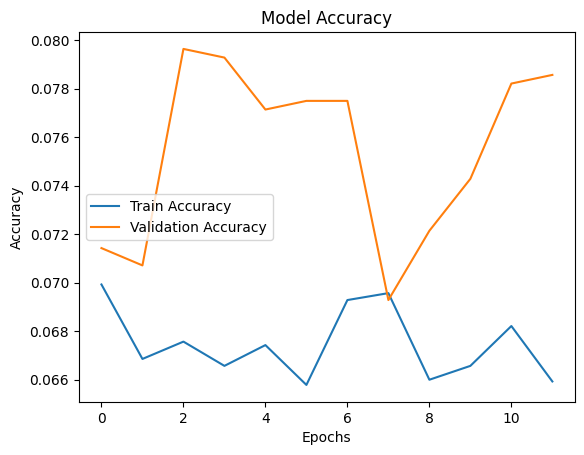

In [34]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

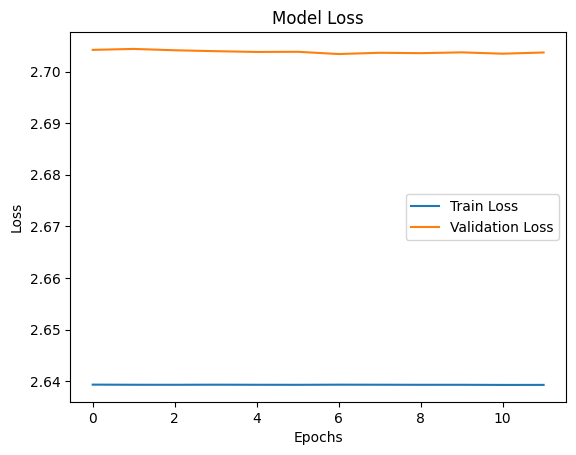

In [35]:
# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## ✨ Create Model
The following functions are used to create the models and train them.

In [41]:
def build_model_gru(hp):
    model = Sequential()

    # First GRU layer with tunable number of units
    model.add(GRU(units=hp.Int('units_gru_1', min_value=64, max_value=256, step=64), input_shape=(IMG_HEIGHT, IMG_WIDTH * 3), return_sequences=True))

    # Second GRU layer with tunable number of units
    model.add(GRU(units=hp.Int('units_gru_2', min_value=32, max_value=128, step=32)))

    # Dropout layer with tunable rate
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense layer with tunable number of units
    model.add(Dense(units=hp.Int('units_dense', min_value=16, max_value=64, step=16), activation='relu'))

    # Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Return the model
    return model

In [42]:
# Initialize the tuner for GRU
tuner = kt.Hyperband(
    build_model_gru,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='GRU'
)

In [43]:
# Early stopping to avoid overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
# Run the hyperparameter search
tuner.search(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    callbacks=[stop_early],
    batch_size=BATCH_SIZE
)

Trial 30 Complete [00h 04m 00s]
val_accuracy: 0.08785714209079742

Best val_accuracy So Far: 0.09321428835391998
Total elapsed time: 01h 23m 22s


In [45]:
# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Units in GRU Layer 1: {best_hps.get('units_gru_1')}
- Units in GRU Layer 2: {best_hps.get('units_gru_2')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Units in Dense Layer: {best_hps.get('units_dense')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best hyperparameters:
- Units in GRU Layer 1: 192
- Units in GRU Layer 2: 128
- Dropout Rate: 0.4
- Units in Dense Layer: 64
- Learning Rate: 0.0001



In [46]:
# Build the best GRU model and retrain it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[stop_early]
)

Epoch 1/20


2025-01-20 11:23:45.296033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:23:45.680839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:23:45.769589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:23:45.956343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:23:46.056386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 2.6391 - accuracy: 0.0672

2025-01-20 11:24:07.663141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:24:07.733593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:24:07.796520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 25s 53ms/step - loss: 2.6391 - accuracy: 0.0672 - val_loss: 2.7428 - val_accuracy: 0.0818
Epoch 2/20
438/438 [==============================] - 17s 38ms/step - loss: 2.6391 - accuracy: 0.0686 - val_loss: 2.7428 - val_accuracy: 0.0843
Epoch 3/20
438/438 [==============================] - 17s 38ms/step - loss: 2.6391 - accuracy: 0.0665 - val_loss: 2.7428 - val_accuracy: 0.0829
Epoch 4/20
438/438 [==============================] - 17s 38ms/step - loss: 2.6391 - accuracy: 0.0658 - val_loss: 2.7428 - val_accuracy: 0.0836
Epoch 5/20
438/438 [==============================] - 17s 39ms/step - loss: 2.6391 - accuracy: 0.0650 - val_loss: 2.7428 - val_accuracy: 0.0832
Epoch 6/20
438/438 [==============================] - 17s 39ms/step - loss: 2.6391 - accuracy: 0.0660 - val_loss: 2.7428 - val_accuracy: 0.0836


In [47]:
# Save Model
best_model.save(f"{MODELS_PATH}/mpox_lesion_identification_gru.h5")

## 🛠️ Train and Evaluate Models

The following code explains how to train and evaluate the models.

In [48]:
# Evaluate the best GRU model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.2f}")

88/88 [==============================] - 2s 15ms/step - loss: 2.7428 - accuracy: 0.0746
Test Accuracy with Best Hyperparameters: 0.07


In [49]:
# Generate classification report
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

2025-01-20 11:25:42.941466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/88 [=>............................] - ETA: 0s  

2025-01-20 11:25:43.179018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-20 11:25:43.251124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step
                               precision    recall  f1-score   support

            Actinic keratoses       0.09      0.05      0.06       200
         Basal cell carcinoma       0.00      0.00      0.00       200
Benign keratosis-like lesions       0.00      0.00      0.00       200
                   Chickenpox       0.00      0.00      0.00       200
                       Cowpox       0.07      0.43      0.11       200
               Dermatofibroma       0.00      0.00      0.00       200
                         HFMD       0.00      0.00      0.00       200
                      Healthy       0.05      0.01      0.01       200
                      Measles       0.11      0.14      0.13       200
             Melanocytic nevi       0.00      0.00      0.00       200
                     Melanoma       0.08      0.41      0.14       200
                    Monkeypox       0.00      0.00      0.00       200
      Squamous cell ca

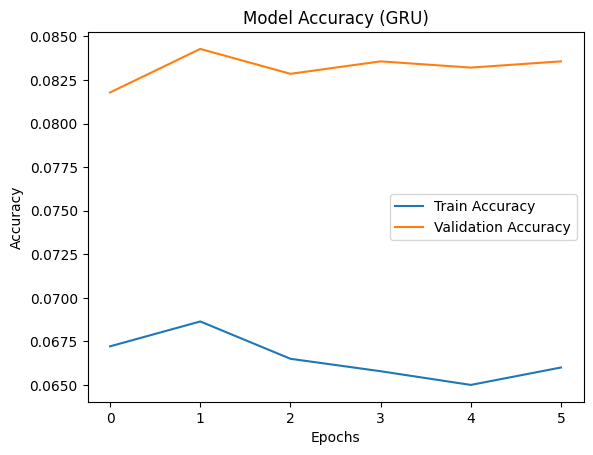

In [50]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

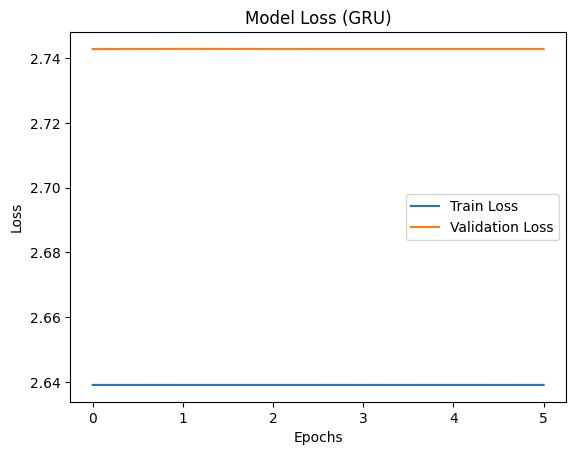

In [51]:
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()